# Mushroom Classification

###### In the project, I try to classify a mushroom by a set of physical attributes and identify the most significant ones. In the first part I'm going to classify by all features. In the second, I'll try to make a determinative algorithm that detects mushroom poisonousness without any additional knowledge other than its appearance.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import graphviz

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
from catboost import Pool, CatBoostClassifier
import shap

from collections import Counter
from IPython.display import display, Image

pd.set_option('display.max_columns', 25)

### Dataset information

Lets look at the dataset and the summary

In [2]:
df = pd.read_csv('mushrooms.csv')
df

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,e,k,s,n,f,n,a,c,b,y,e,?,s,s,o,o,p,o,o,p,b,c,l
8120,e,x,s,n,f,n,a,c,b,y,e,?,s,s,o,o,p,n,o,p,b,v,l
8121,e,f,s,n,f,n,a,c,b,n,e,?,s,s,o,o,p,o,o,p,b,c,l
8122,p,k,y,n,f,y,f,c,n,b,t,?,s,k,w,w,p,w,o,e,w,v,l


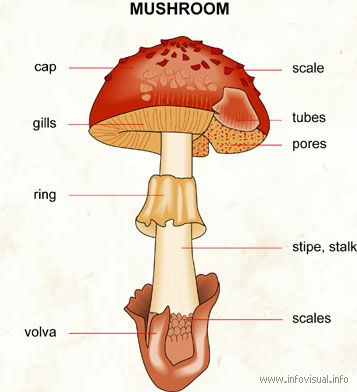

In [3]:
Image(filename='mushroom.jpg') 

In [4]:
df.describe()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,2,5,4,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,t,b,s,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,4608,3776,5176,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


There are no missing values in the table.

Lets plot the distribution of target variable

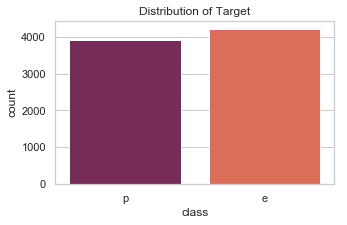

In [5]:
y_dist = dict(Counter(df['class'].values))

xx = list(y_dist.keys())
yy = list(y_dist.values())

plt.figure(figsize=(5,3))
sns.set(style='whitegrid')
ax = sns.barplot(xx, yy, palette='rocket')
ax.set_title('Distribution of Target')
ax.set_ylabel('count');
ax.set_xlabel('class');

The target class is well balanced.

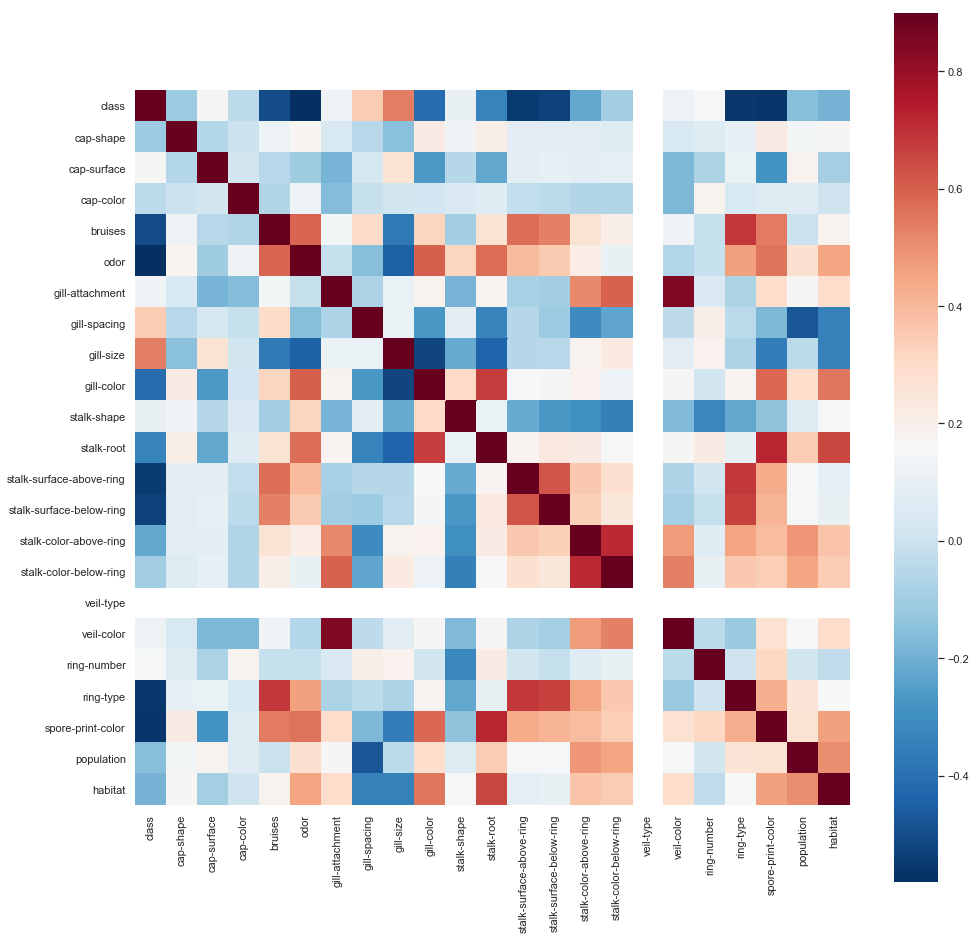

In [6]:
corr = df.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
plt.figure(figsize=(16,16))
sns.heatmap(corr, cmap = 'RdBu_r', vmax=0.9, square=True)

Feature "veil-type" contains only one possible kind of value.

Let's look at high correlation on class columns

In [7]:
IF = corr['class'].sort_values(ascending=False).head(10).to_frame()
IF.head(8)

,class
class,1.000000
gill-size,0.540024
gill-spacing,0.348387
cap-surface,0.169663
ring-number,0.152261
gill-attachment,0.129200
veil-color,0.120766
stalk-shape,0.102019


gill-size  class
b          e        3920
           p        1692
n          p        2224
           e         288
Name: class, dtype: int64


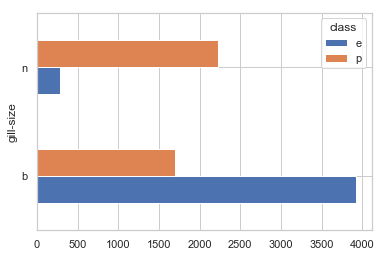

In [8]:
print(df.groupby('gill-size')['class'].value_counts())
df.groupby('gill-size')['class'].value_counts().unstack().plot.barh()

The highest correlation with target class means that almost all mushroom with narrow gill size are posionous and around 60% of broad gill-size are edible. I think broad gill size mushroom are highly edible than narrow gill size mushroom.

gill-spacing  class
c             p        3804
              e        3008
w             e        1200
              p         112
Name: class, dtype: int64


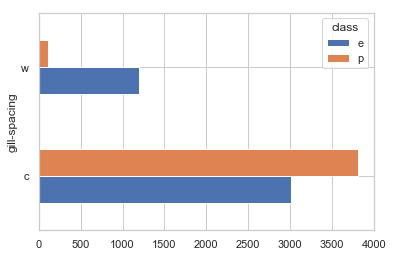

In [9]:
print(df.groupby('gill-spacing')['class'].value_counts())
df.groupby('gill-spacing')['class'].value_counts().unstack().plot.barh()

Almost all crowded gill spacing mushroom are edible and around 40% of close gill-spacing are edible. It's better to eat crowded gill spacing mushroom.

cap-surface  class
f            e        1560
             p         760
g            p           4
s            p        1412
             e        1144
y            p        1740
             e        1504
Name: class, dtype: int64


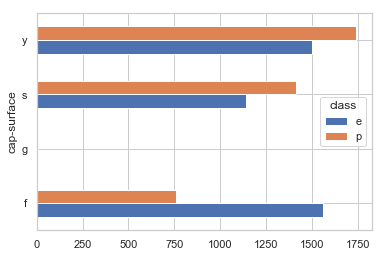

In [10]:
print(df.groupby('cap-surface')['class'].value_counts())
df.groupby('cap-surface')['class'].value_counts().unstack().plot.barh()

Almost all mushroom with smooth and scaly cap surface are highly posionous, while mushroom with grooves cap surface is also posionous, and fibrous cap surface are highly edible. I think only fibrous cap surfaced mushroom are safe to consume.

ring-number  class
n            p          36
o            p        3808
             e        3680
t            e         528
             p          72
Name: class, dtype: int64


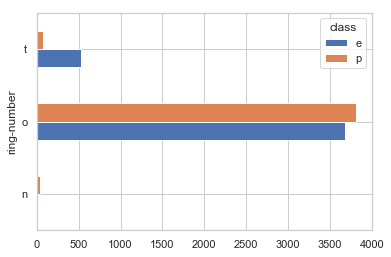

In [11]:
print(df.groupby('ring-number')['class'].value_counts())
df.groupby('ring-number')['class'].value_counts().unstack().plot.barh()

All the mushroom with two ring number is highly edible than the other.

gill-attachment  class
a                e         192
                 p          18
f                e        4016
                 p        3898
Name: class, dtype: int64


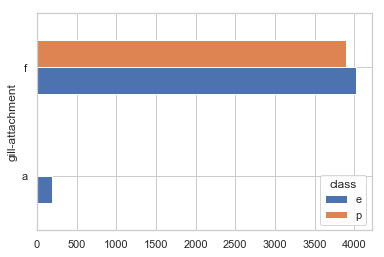

In [12]:
print(df.groupby('gill-attachment')['class'].value_counts())
df.groupby('gill-attachment')['class'].value_counts().unstack().plot.barh()

Almost all the mushroom with attached gill is 100% edible than the other.

veil-color  class
n           e          96
o           e          96
w           e        4016
            p        3908
y           p           8
Name: class, dtype: int64


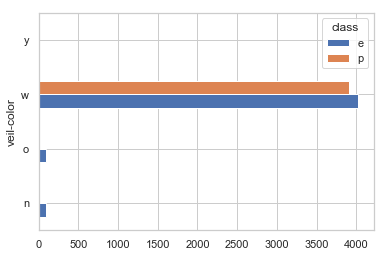

In [13]:
print(df.groupby('veil-color')['class'].value_counts())
df.groupby('veil-color')['class'].value_counts().unstack().plot.barh()

All orange or brown mushrooms are edible, and yellow veil colored mushrooms are posionous.

### Preprocessing

In [3]:
data = df.drop(['veil-type'], axis=1)
data = data.replace({'class': {'e': 0, 'p': 1}})

In [4]:
y = data.iloc[:, 0]
X = data.iloc[:, 1:]

In [5]:
X_dummy = pd.get_dummies(X)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dummy, y, train_size=0.8, random_state=42)

In [7]:
def generate_auc(y_test, y_pred, model_name):
    auc_scr = roc_auc_score(y_test, y_pred)
    print('The AUC for ' + model_name + ' is:', auc_scr)

    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, 'purple', label = 'AUC = %0.2f' % roc_auc)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([-0.01, 1])
    plt.ylim([0, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('AUC ROC')
    plt.legend()
    plt.show()

In [8]:
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(6,5));
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['e', 'p'])
    plt.yticks(tick_marks, ['e', 'p'])
    plt.grid(False)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment='center', 
                 color='white' if cm[i, j] > thresh else 'black')
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Decision tree

Lets train a decision tree classifier

The AUC for decision tree classifier is: 1.0


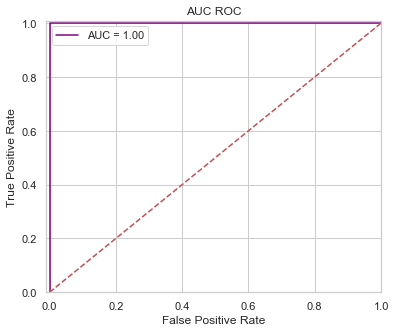

In [20]:
model1 = DecisionTreeClassifier(criterion='entropy', random_state=42)
model1.fit(X_train, y_train)
y_pred = model1.predict(X_test)
generate_auc(y_test, y_pred, 'decision tree classifier')

<Figure size 432x360 with 0 Axes>

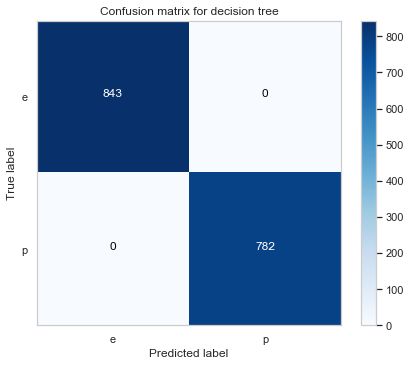

In [21]:
cnf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5));
plot_confusion_matrix(cnf_matrix, 'Confusion matrix for decision tree');
plt.show()

In [22]:
f_imp = model1.feature_importances_
non_zero = np.count_nonzero(f_imp)
print('Number of non-zero feature importances:', non_zero)

Number of non-zero feature importances: 9


In [23]:
idx = f_imp.argsort()[::-1]
n_max = min(non_zero, 10)
pd.DataFrame({'Feature': X_train.columns[idx][:n_max],
              'Importance': f_imp[idx][:n_max]})

,Feature,Importance
0,odor_n,0.534914
1,bruises_f,0.220891
2,stalk-root_c,0.067623
3,spore-print-color_r,0.048756
4,stalk-root_r,0.046010
5,gill-spacing_w,0.044452
6,stalk-surface-below-ring_y,0.026971
7,ring-number_o,0.005855
8,gill-size_b,0.004528


odor  class
a     e         400
c     p         192
f     p        2160
l     e         400
m     p          36
n     e        3408
      p         120
p     p         256
s     p         576
y     p         576
Name: class, dtype: int64


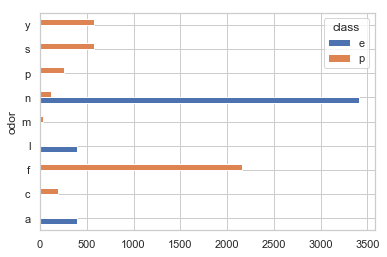

In [48]:
print(df.groupby('odor')['class'].value_counts())
df.groupby('odor')['class'].value_counts().unstack().plot.barh()

bruises  class
f        p        3292
         e        1456
t        e        2752
         p         624
Name: class, dtype: int64


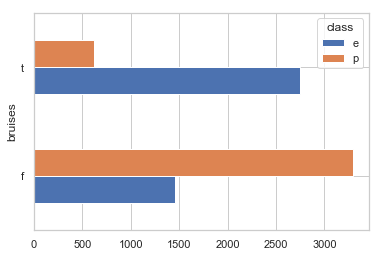

In [49]:
print(df.groupby('bruises')['class'].value_counts())
df.groupby('bruises')['class'].value_counts().unstack().plot.barh()

AUC and accuracy scores 1 - very good result. From features importences we can see that top importance features are negative correlative with the target class. Bar shows that the odor and bruises almost certainly set poisonousness. 80% edible mushrooms have none odor, and 85% poisonous have no bruises. 

### Random forest

Now, lets train a tree based model : random forest

The AUC for random forest classifier is: 1.0


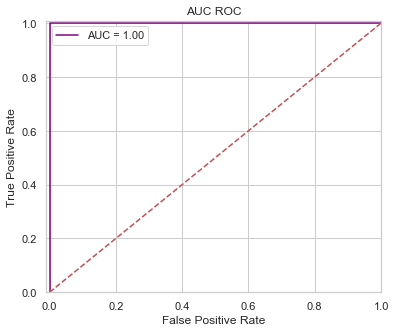

In [24]:
model2 = RandomForestClassifier(criterion='entropy', random_state=42)
model2.fit(X_train, y_train)
y_pred = model1.predict(X_test)
generate_auc(y_test, y_pred, 'random forest classifier')

<Figure size 432x360 with 0 Axes>

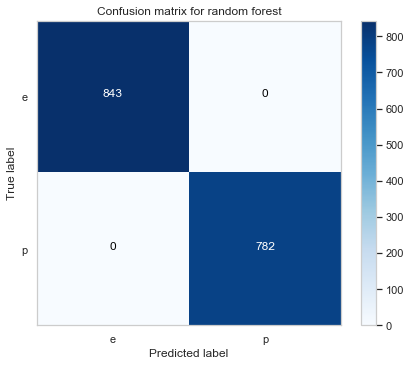

In [25]:
cnf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5));
plot_confusion_matrix(cnf_matrix, 'Confusion matrix for random forest');
plt.show()

In [26]:
f_imp = model2.feature_importances_
non_zero = np.count_nonzero(f_imp)
print('Number of non-zero feature importances:', non_zero)

Number of non-zero feature importances: 111


In [27]:
idx = f_imp.argsort()[::-1]
n_max = min(non_zero, 10)
pd.DataFrame({'Feature': X_train.columns[idx][:n_max],
              'Importance': f_imp[idx][:n_max]})

,Feature,Importance
0,odor_n,0.096667
1,gill-size_b,0.066791
2,stalk-surface-above-ring_k,0.059798
3,odor_f,0.059784
4,gill-size_n,0.044384
5,spore-print-color_h,0.040394
6,gill-color_b,0.039332
7,stalk-surface-below-ring_k,0.032714
8,ring-type_l,0.030660
9,ring-type_p,0.028061


stalk-surface-above-ring  class
f                         e         408
                          p         144
k                         p        2228
                          e         144
s                         e        3640
                          p        1536
y                         e          16
                          p           8
Name: class, dtype: int64


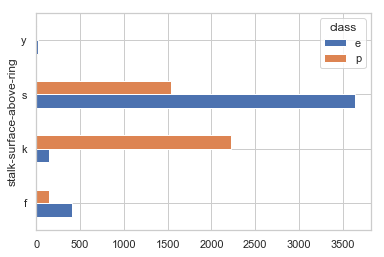

In [51]:
print(df.groupby('stalk-surface-above-ring')['class'].value_counts())
df.groupby('stalk-surface-above-ring')['class'].value_counts().unstack().plot.barh()

AUC and accuracy scores the same 1. Features importences are distributed approximately evenly. In top we can see odor again, positive correlated gill size and stalk surface above ring. Almost all silky surface are poisonous.

### Catboost

Finally, lets train a tree based boosting model: catboost

In [9]:
X_encod = X.copy()
le = LabelEncoder()
for column in X.columns:
    X_encod[column] = le.fit_transform(X[column])
X_train, X_test, y_train, y_test = train_test_split(X_encod, y, train_size=0.8, random_state=42)

In [10]:
cat_features = range(X_encod.shape[1])
train_pool = Pool(data=X_train,
                  label=y_train,
                  cat_features=cat_features,
                  feature_names=list(X.columns),
                 )
test_pool = Pool(data=X_test,
                 label=y_test,
                 cat_features=cat_features,
                 feature_names=list(X.columns),
                )

In [11]:
model = CatBoostClassifier(iterations=100,
                           verbose=50,
                           custom_metric=['Accuracy', 'AUC:hints=skip_train~false'],
                           random_state=42)
model.fit(train_pool,
          eval_set=test_pool,
          plot=True,
         )

Learning rate set to 0.136988


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3952947	test: 0.3960405	best: 0.3960405 (0)	total: 97.1ms	remaining: 9.62s
50:	learn: 0.0017282	test: 0.0012885	best: 0.0012885 (50)	total: 819ms	remaining: 787ms
99:	learn: 0.0012747	test: 0.0009450	best: 0.0009450 (99)	total: 1.48s	remaining: 0us

bestTest = 0.0009450428008
bestIteration = 99



In [12]:
model.get_feature_importance(test_pool, 'LossFunctionChange', prettified=True).head(10)

,Feature Id,Importances
0,odor,0.161599
1,spore-print-color,0.020903
2,gill-size,0.002702
3,stalk-surface-below-ring,0.000912
4,stalk-surface-above-ring,0.000513
5,cap-surface,0.000151
6,gill-spacing,0.000150
7,bruises,0.000120
8,population,0.000097
9,veil-color,0.000074


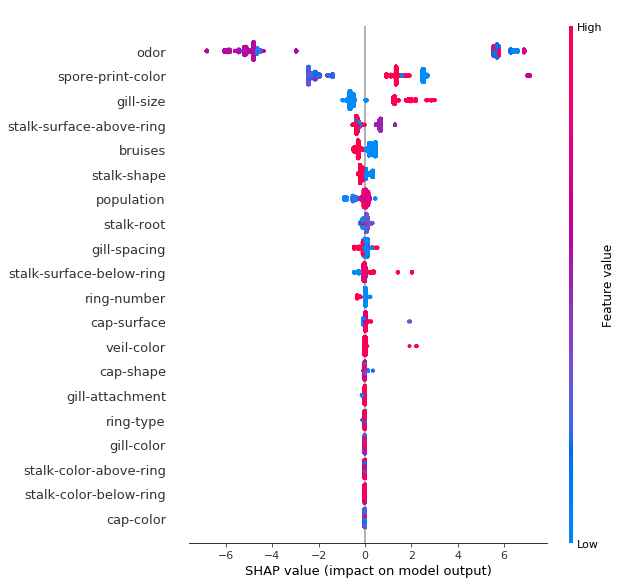

In [13]:
shap_values = model.get_feature_importance(
    train_pool, 
    'ShapValues',
)
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]
shap.summary_plot(shap_values, X_train)

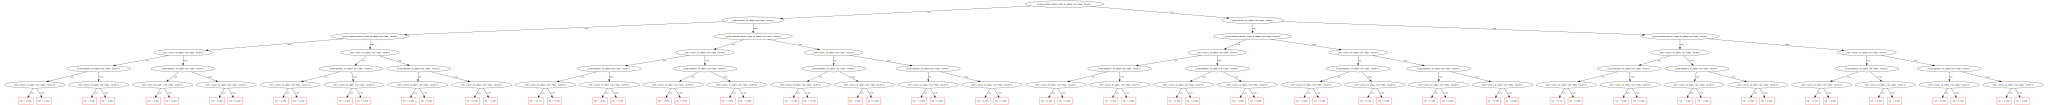

In [14]:
display(model.plot_tree(25, pool=train_pool))

spore-print-color  class
b                  e          48
h                  p        1584
                   e          48
k                  e        1648
                   p         224
n                  e        1744
                   p         224
o                  e          48
r                  p          72
u                  e          48
w                  p        1812
                   e         576
y                  e          48
Name: class, dtype: int64


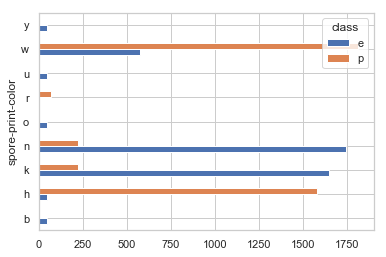

In [52]:
print(df.groupby('spore-print-color')['class'].value_counts())
df.groupby('spore-print-color')['class'].value_counts().unstack().plot.barh()

Here I can conclude that odor and spore print colot uniquely determine a lot of mushrooms. The rest are determined mainly due to gill size and stalk surface above ring. Unfortunately, the tree itself cannot be printed clearly.

###### The main attributes of mushroom poisoning are odor, spore print color, bruises. Another important attributes are gill size and stalk surface above ring.

### Get algorithm

I think features: odor, spore-print-color, population and habitat can't be detected by mushroom appearance. Lets remove them, try to build decision tree and draw them

In [15]:
data_new = data.drop(['odor', 'spore-print-color', 'population', 'habitat'], axis=1)

In [16]:
y_new = data_new.iloc[:, 0]
X_new = pd.get_dummies(data_new.iloc[:, 1:])
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, train_size=0.8, random_state=42)

The AUC for decision tree classifier is: 0.9981743741903384


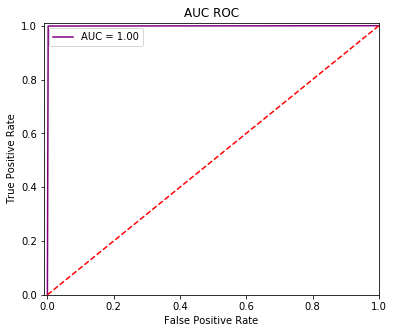

In [17]:
clf = DecisionTreeClassifier(criterion='entropy', random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
generate_auc(y_test, y_pred, 'decision tree classifier')

<Figure size 432x360 with 0 Axes>

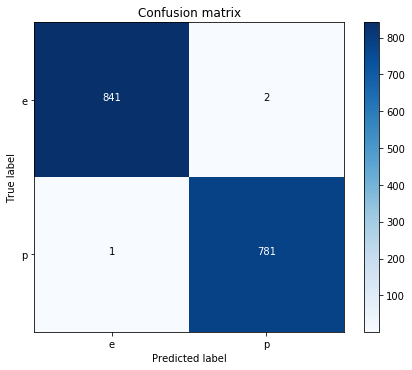

In [18]:
cnf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5));
plot_confusion_matrix(cnf_matrix, 'Confusion matrix');
plt.show()

In [19]:
f_imp = clf.feature_importances_
non_zero = np.count_nonzero(f_imp)
print('Number of non-zero feature importances:', non_zero)

Number of non-zero feature importances: 20


In [20]:
idx = f_imp.argsort()[::-1]
n_max = min(non_zero, 10)
pd.DataFrame({'Feature': X_train.columns[idx][:n_max],
              'Importance': f_imp[idx][:n_max]})

,Feature,Importance
0,stalk-surface-above-ring_k,0.290777
1,gill-size_n,0.269653
2,stalk-root_b,0.137019
3,ring-type_p,0.096149
4,cap-surface_s,0.049436
5,gill-color_b,0.042509
6,gill-color_w,0.026364
7,bruises_f,0.020715
8,ring-number_t,0.017428
9,stalk-shape_e,0.017200


The two most important features are the same.

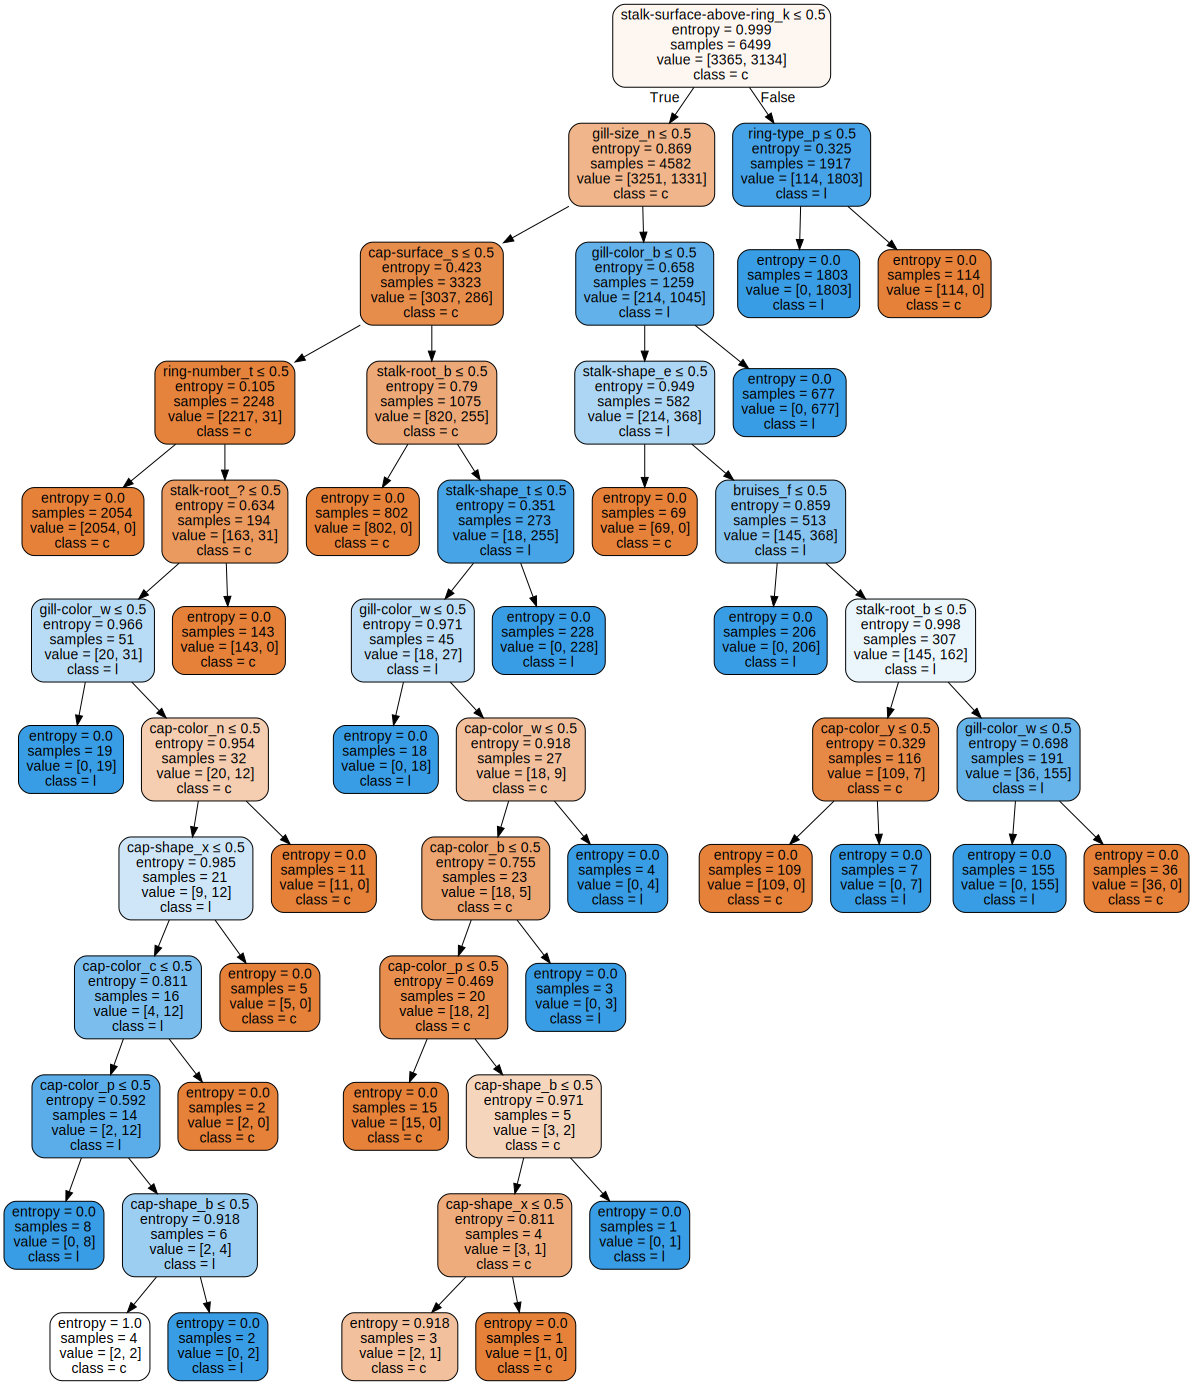

In [21]:
dot_data = export_graphviz(clf, out_file=None, 
                     feature_names=X_train.columns,  
                     class_names=y_train.name,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph.render('tree', cleanup=True, format='png')
graph